In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

## **Data Collection**

In this project we are using two NASA data sources to study natural disaster events and their surrounding climate conditions.

**NASA EONET (Earth Observatory Natural Event Tracker)** This dataset provides near–real-time information on natural disasters worldwide, including events such as wildfires and severe storms. For each event, EONET records the event title, category, date, geographic coordinates (latitude and longitude) and source information. This dataset forms the core event level data used in the project.

**NASA POWER API (Prediction of Worldwide Energy Resources)**. We are using this dataset to understand the environmental context of each disaster. The POWER API supplies global meteorological variables derived from satellite and reanalysis data. For each EONET event, climate conditions were retrieved using the event’s location and date.

The climate variables used in this project include:

* **Temperature (T2M)** – near-surface air temperature
* **Relative Humidity (RH2M)** – moisture content of the air
* **Wind Speed (WS2M)** – near-surface wind speed
* **Precipitation (PRECTOT)** – total precipitation

By combining NASA EONET disaster records with NASA POWER climate data, a unified dataset was created that links each natural disaster event with localized climate conditions. This integrated dataset supports exploratory analysis and future machine learning tasks throughout the project.

In [23]:
EONET_URL = "https://eonet.gsfc.nasa.gov/api/v3/events"
POWER_URL = "https://power.larc.nasa.gov/api/temporal/daily/point"
params = {"status": "open", "limit": 5000}

response = requests.get(EONET_URL, params=params)
data = response.json()

In [24]:
events = []
for event in data["events"]:
    if event["geometry"]:
        geom = event["geometry"][-1]
        events.append({
            "id": event["id"],
            "title": event["title"],
            "category": event["categories"][0]["title"],
            "date": geom["date"],
            "longitude": geom["coordinates"][0],
            "latitude": geom["coordinates"][1],
            "source": event["sources"][0]["url"]})

df = pd.DataFrame(events)
df.head()

,id,title,category,date,longitude,latitude,source
0,EONET_17537,Tropical Cyclone 18P,Severe Storms,2026-01-29T12:00:00Z,172.500000,-26.200000,https://www.metoc.navy.mil/jtwc/products/sh182...
1,EONET_17453,"SACATON RX Prescribed Fire, Socorro, New Mexico",Wildfires,2026-01-23T15:40:00Z,-106.617583,34.038500,https://irwin.doi.gov/observer/incidents/5b75a...
2,EONET_17454,"RX Nueces 0577 Prescribed Fire, Nueces, Texas",Wildfires,2026-01-22T17:43:00Z,-97.166667,27.701389,https://irwin.doi.gov/observer/incidents/67ef0...
3,EONET_17455,"APQ Area 5 Rx 0122 Prescribed Fire, Polk, Florida",Wildfires,2026-01-22T08:59:00Z,-81.242182,27.701885,https://irwin.doi.gov/observer/incidents/b1aa9...
4,EONET_17452,"East Lake (11) Wildfire, Collier, Florida",Wildfires,2026-01-21T19:25:00Z,-81.345000,26.091111,https://irwin.doi.gov/observer/incidents/feb87...


In [25]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

df.isna().sum()

,0
id,0
title,0
category,0
date,0
longitude,0
latitude,0
source,0
year,0
month,0


In [26]:
df = df[(df["latitude"].between(-90, 90)) &
    (df["longitude"].between(-180, 180))]

In [27]:
def get_power_data(lat, lon, date):
    start = (date - timedelta(days=3)).strftime("%Y%m%d")
    end = date.strftime("%Y%m%d")
    params = {
        "parameters": "T2M,RH2M,WS2M,PRECTOT",
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start,
        "end": end,
        "format": "JSON"}

    r = requests.get(POWER_URL, params=params)
    if r.status_code != 200:
        return None

    js = r.json()["properties"]["parameter"]
    return {
        "temp": np.mean(list(js["T2M"].values())),
        "humidity": np.mean(list(js["RH2M"].values())),
        "wind": np.mean(list(js["WS2M"].values())),
        "precip": np.mean(list(js["PRECTOTCORR"].values()))}

In [28]:
sample_df = df.sample(150, random_state=42)

climate_data = []

for _, row in sample_df.iterrows():
    climate = get_power_data(row["latitude"], row["longitude"], row["date"])
    if climate:
        climate_data.append({**row.to_dict(), **climate})

combined_df = pd.DataFrame(climate_data)
combined_df.head()


,id,title,category,date,longitude,latitude,source,year,month,temp,humidity,wind,precip
0,EONET_12380,Wildfire in Mauritania 1023279,Wildfires,2025-01-08 19:00:00+00:00,-11.949746,15.702602,https://www.gdacs.org/report.aspx?eventtype=WF...,2025,1,21.7525,26.9700,3.775,0.0000
1,EONET_11299,Wildfire in Bolivia 1022383,Wildfires,2024-09-18 19:00:00+00:00,-66.689224,-12.491606,https://www.gdacs.org/report.aspx?eventtype=WF...,2024,9,28.7025,52.4000,1.375,1.9950
2,EONET_11206,Wildfire in Australia 1022299,Wildfires,2024-09-15 19:00:00+00:00,122.366280,-17.208015,https://www.gdacs.org/report.aspx?eventtype=WF...,2024,9,29.9025,51.3175,3.880,0.0125
3,EONET_13015,"SMR CPT 311 Rx 0307 Wildfire, Wakulla, Florida",Wildfires,2025-03-10 14:19:00+00:00,-84.415889,30.015444,https://irwin.doi.gov/observer/,2025,3,16.7725,88.8150,1.695,17.9275
4,EONET_13333,Wildfire in Russian Federation 1023688,Wildfires,2025-04-12 19:00:00+00:00,116.445842,53.557606,https://www.gdacs.org/report.aspx?eventtype=WF...,2025,4,-3.4175,52.5475,0.935,0.2125


In [29]:
combined_df.dropna(inplace=True)
combined_df.describe()

,longitude,latitude,year,month,temp,humidity,wind,precip
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,-8.649365,10.297905,2024.393333,6.953333,22.025767,47.638683,1.860783,0.848583
std,96.823403,28.809758,0.542139,2.892565,7.941846,19.291593,1.258029,3.173992
min,-178.990000,-69.020000,2024.000000,1.000000,-3.417500,12.700000,0.007500,0.000000
25%,-96.917525,-14.313647,2024.000000,6.000000,18.115000,31.456250,0.531875,0.000000
50%,-44.715706,3.415281,2024.000000,8.000000,22.408750,48.172500,2.001250,0.010000
75%,89.928007,36.838316,2025.000000,9.000000,27.831875,61.817500,2.707500,0.425000
max,149.248333,69.272785,2026.000000,12.000000,35.250000,89.622500,5.442500,31.857500


In [30]:
feature_summary = pd.DataFrame({
    "Feature Name": combined_df.columns,
    "Data Type": [
        "Categorical","Text","Categorical","Datetime",
        "Numerical","Numerical","Text",
        "Numerical","Numerical","Numerical","Numerical",
        "Numerical","Numerical"]})

feature_summary

,Feature Name,Data Type
0,id,Categorical
1,title,Text
2,category,Categorical
3,date,Datetime
4,longitude,Numerical
5,latitude,Numerical
6,source,Text
7,year,Numerical
8,month,Numerical
9,temp,Numerical


In [31]:
combined_df[["temp","humidity","wind","precip"]].mean()
combined_df[["temp","humidity","wind","precip"]].median()

,0
temp,22.40875
humidity,48.17250
wind,2.00125
precip,0.01000


#EDA

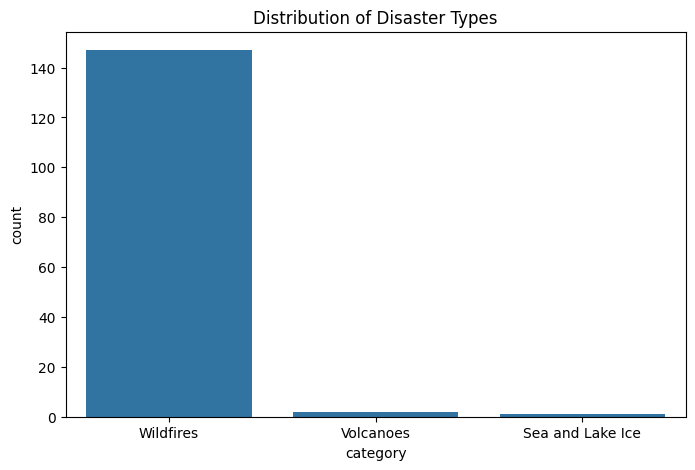

In [32]:
plt.figure(figsize=(8,5))
sns.countplot(data=combined_df, x="category")
plt.title("Distribution of Disaster Types")
plt.show()

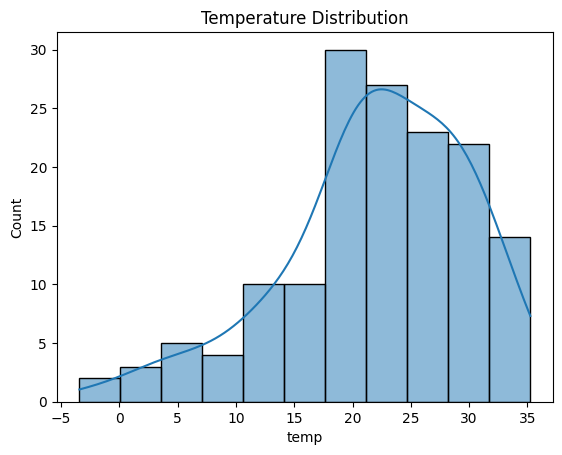

In [33]:
sns.histplot(combined_df["temp"], kde=True)
plt.title("Temperature Distribution")
plt.show()

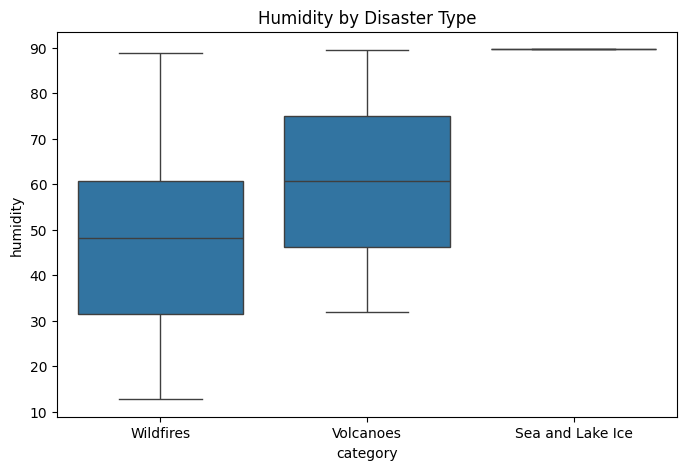

In [34]:
plt.figure(figsize=(8,5))
sns.boxplot(data=combined_df, x="category", y="humidity")
plt.title("Humidity by Disaster Type")
plt.show()

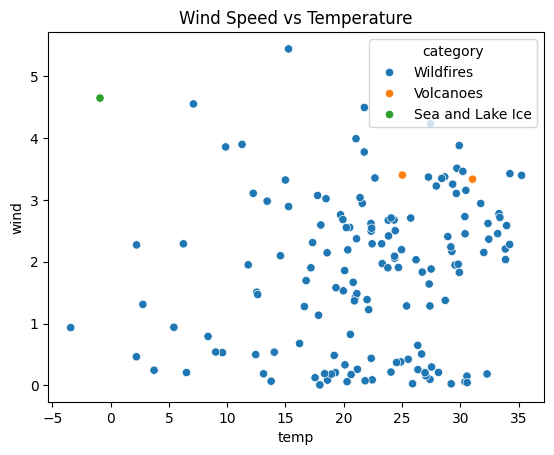

In [35]:
sns.scatterplot(data=combined_df,x="temp",y="wind",hue="category")
plt.title("Wind Speed vs Temperature")
plt.show()

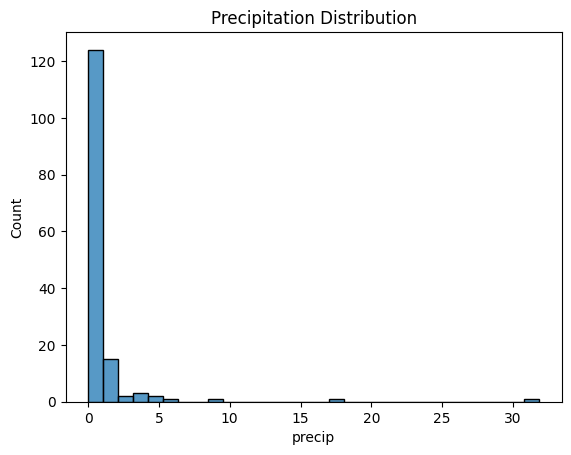

In [36]:
sns.histplot(combined_df["precip"], bins=30)
plt.title("Precipitation Distribution")
plt.show()


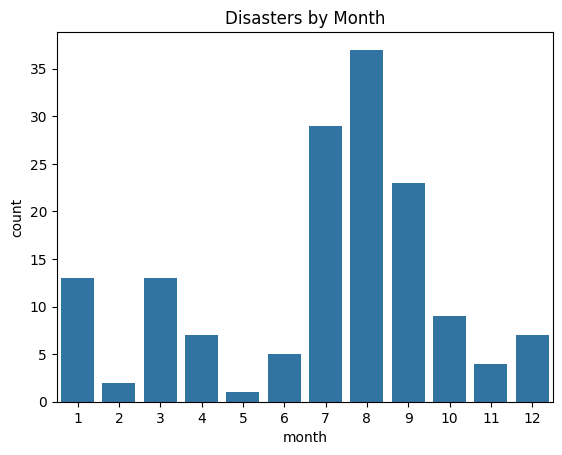

In [37]:
sns.countplot(x="month", data=combined_df)
plt.title("Disasters by Month")
plt.show()


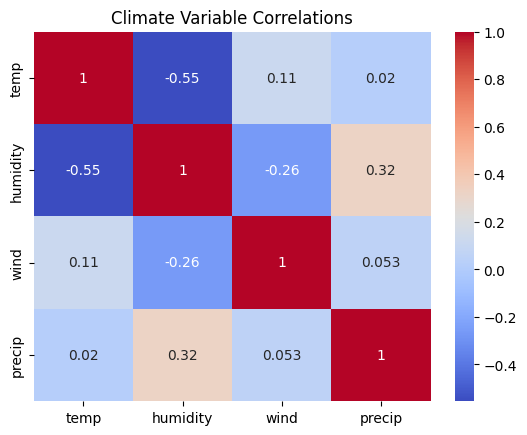

In [38]:
corr = combined_df[["temp","humidity","wind","precip"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Climate Variable Correlations")
plt.show()


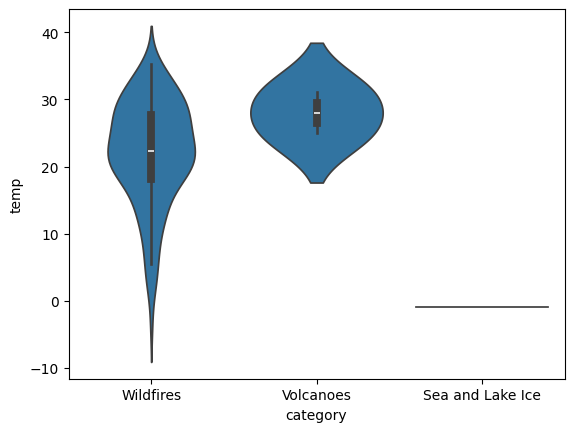

In [39]:
sns.violinplot(data=combined_df, x="category", y="temp")
plt.show()


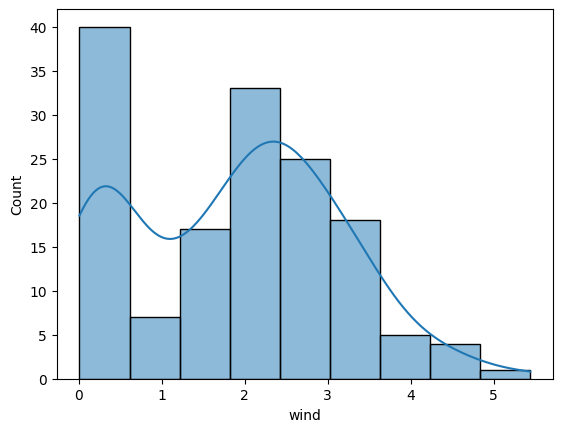

In [40]:
sns.histplot(combined_df["wind"], kde=True)
plt.show()


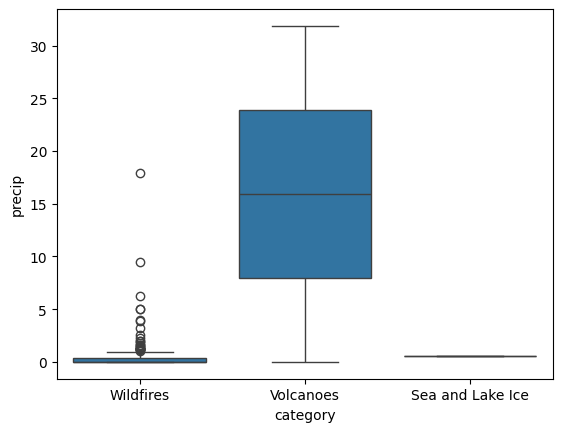

In [41]:
sns.boxplot(data=combined_df, x="category", y="precip")
plt.show()


In [42]:
len(df)

5000